# This notebook contains defining a neural network and searching hyperparameters with Optuna, bayesopt



In [ ]:
!wget https://raw.githubusercontent.com/angeltamang123/Nepali-Hate-Sentiment-Detection/refs/heads/main/Project/Part%202/Data/Preprocessed/Cleaned_Nepali_dataset.csv

--2025-01-12 15:59:45--  https://raw.githubusercontent.com/angeltamang123/Nepali-Hate-Sentiment-Detection/refs/heads/main/Project/Part%202/Data/Preprocessed/Cleaned_Nepali_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467029 (456K) [text/plain]
Saving to: ‘Cleaned_Nepali_dataset.csv’

Cleaned_Nepali_data 100%[===================>] 456.08K  --.-KB/s    in 0.02s   

2025-01-12 15:59:45 (18.1 MB/s) - ‘Cleaned_Nepali_dataset.csv’ saved [467029/467029]



## The embeddings are generated using SONAR with 1024 dimensions, with train and testing split of 80:20

In [ ]:
import pandas as pd
import numpy as np

filepath= "/content/Cleaned_Nepali_dataset.csv"
df= pd.read_csv(filepath)

# Setting up torch
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Setting default device to what's available
torch.set_default_device(device)

# The embeddings from SONAR
X_train_sonar= torch.load('X_train_embeddings.pt')
X_test_sonar= torch.load('X_test_embeddings.pt')
y_train_sonar= torch.load('y_train_tensor.pt')
y_test_sonar= torch.load('y_test_tensor.pt')

# Shape verification
print("X_train shape", X_train_sonar.shape)
print("X_test shape", X_test_sonar.shape)
print("y_train shape", y_train_sonar.shape)
print("y_test shape", y_test_sonar.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Cleaned_Nepali_dataset.csv'

In [ ]:
# Defining Network

import torch.nn as nn
import torch.optim as optim

# Defining neural network
class Sonar_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU, dropout= 0.5):
        super(Sonar_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialization
input_dim = 1024       # Dimension of SONAR embeddings
hidden_dim = 256       # Number of hidden units(Hyperparameter)
output_dim = len(set(y_train_sonar.numpy()))  # Number of unique classes

model = Sonar_Classifier(input_dim, hidden_dim, output_dim) # model with default architecture
model.to(device= device) # Train model in what's available
print(model)

Sonar_Classifier(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


## Weights for Cost-sensitive loss

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Getting Class Weights
y_train_np = y_train_sonar.numpy()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balances based on class frequencies
    classes=np.unique(y_train_np),  # Unique classes in training labels
    y=y_train_np  # Training labels
)
class_weights = class_weights / np.sum(class_weights) # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Normalized Class Weights:", class_weights_tensor)


# loss function and Adam Optimizer
criterion = nn.CrossEntropyLoss(weight= class_weights_tensor)  # For multi-class classification(class weight passaable)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

Normalized Class Weights: tensor([0.0324, 0.0218, 0.1171, 0.3737, 0.2738, 0.1811], device='cuda:0')


### Using WeightRandomSamper such that each batch represent every class equally

In [ ]:
# Data prepration for PyTorch

from torch.utils.data import DataLoader, TensorDataset

# Combine embeddings and labels into TensorDataset
train_dataset = TensorDataset(X_train_sonar, y_train_sonar)
test_dataset = TensorDataset(X_test_sonar, y_test_sonar)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size adjustable
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training an initial Model

Epoch 1/200, Train Loss: 1.7093, Test Loss: 1.7026
Epoch 2/200, Train Loss: 1.6332, Test Loss: 1.6459
Epoch 3/200, Train Loss: 1.5607, Test Loss: 1.5831
Epoch 4/200, Train Loss: 1.4815, Test Loss: 1.5364
Epoch 5/200, Train Loss: 1.4061, Test Loss: 1.4946
Epoch 6/200, Train Loss: 1.3331, Test Loss: 1.4456
Epoch 7/200, Train Loss: 1.2598, Test Loss: 1.4254
Epoch 8/200, Train Loss: 1.2012, Test Loss: 1.3971
Epoch 9/200, Train Loss: 1.1433, Test Loss: 1.3594
Epoch 10/200, Train Loss: 1.0898, Test Loss: 1.3554
Epoch 11/200, Train Loss: 1.0462, Test Loss: 1.3646
Epoch 12/200, Train Loss: 1.0151, Test Loss: 1.3262
Epoch 13/200, Train Loss: 0.9797, Test Loss: 1.3206
Epoch 14/200, Train Loss: 0.9309, Test Loss: 1.3155
Epoch 15/200, Train Loss: 0.8939, Test Loss: 1.2925
Epoch 16/200, Train Loss: 0.8789, Test Loss: 1.3317
Epoch 17/200, Train Loss: 0.8499, Test Loss: 1.2986
Epoch 18/200, Train Loss: 0.8153, Test Loss: 1.3050
Epoch 19/200, Train Loss: 0.7850, Test Loss: 1.3157
Epoch 20/200, Train L

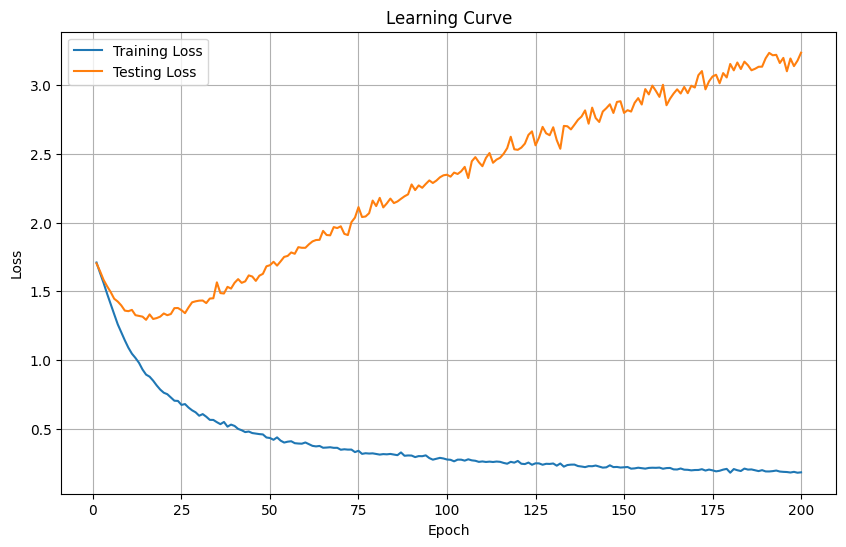

In [ ]:
import matplotlib.pyplot as plt
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Initialize the learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Initialize lists to store training and testing losses
train_losses = []
test_losses = []

# Training and evaluation loop
epochs = 200  # Number of epochs
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.long())  # Ensure labels are long type
        loss.backward()
        # Prevent exploading gradients by clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)  # Average loss for training
    train_losses.append(train_loss)

    # Testing phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            test_loss += loss.item()
    test_loss /= len(test_loader)  # Average loss for testing
    test_losses.append(test_loss)

    # # Update learning rate based on test loss
    # scheduler.step(test_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       174
           1       0.68      0.62      0.65       278
           2       0.13      0.16      0.15        49
           3       0.33      0.35      0.34        20
           4       0.26      0.23      0.24        22
           5       0.22      0.28      0.24        29

    accuracy                           0.59       572
   macro avg       0.40      0.40      0.40       572
weighted avg       0.60      0.59      0.59       572



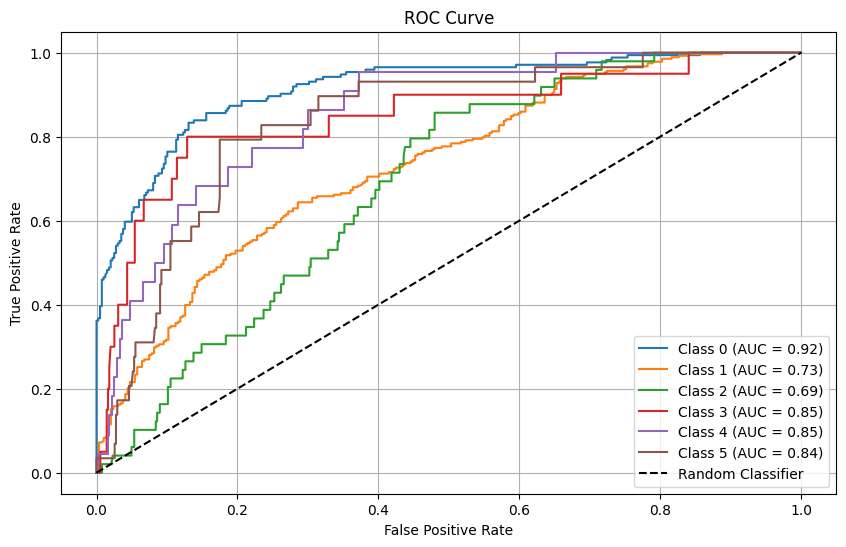

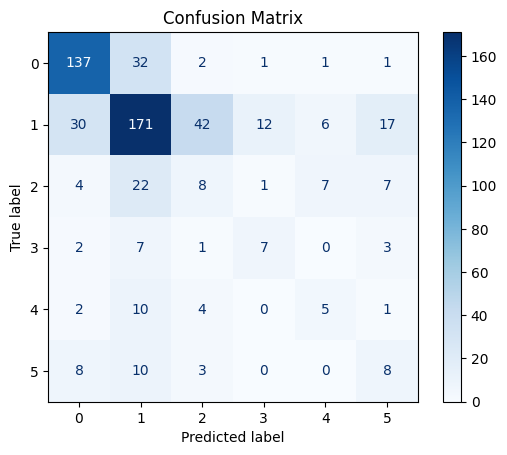

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set, generate a classification report, plot the ROC curve,
    and display the confusion matrix.

    Parameters:
        model: Trained PyTorch model
        test_loader: DataLoader for the test set

    Returns:
        None
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Model predictions
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted classes

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Determine the number of classes
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # ROC Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_loader)

# Searching Hyperparameters

- Used ray[tune]
- used ASHASchedular and bayesOPT for searching algo

In [ ]:
!pip install ray[tune]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 11.4 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune, train
from ray.tune.schedulers import ASHAScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from ray.tune.search.optuna import OptunaSearch


# Define model class
class Sonar_Classifier_hyperparameters(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU, dropout=0.5):
        super(Sonar_Classifier_hyperparameters, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training function for Ray Tune
def train_model(config):
    # Ensure the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data (make sure the data is on the correct device)
    train_dataset = TensorDataset(X_train_sonar, y_train_sonar)
    test_dataset = TensorDataset(X_test_sonar, y_test_sonar)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)


    # Map activation, retriving from string as searching module directly can clutter logs
    activation_map = {
        "ReLU": nn.ReLU,
        "Tanh": nn.Tanh,
        "LeakyReLU": nn.LeakyReLU
        }

    activation = activation_map[config["activation"]]

    # Initialize model and move it to the correct device
    model = Sonar_Classifier_hyperparameters(
        input_dim=1024,
        hidden_dim=config["hidden_dim"],
        output_dim=len(set(y_train_sonar.numpy())),
        activation=activation,
        dropout=config["dropout"]
    )
    print(model)
    model.to(device)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_sonar.numpy()),
        y=y_train_sonar.numpy()
    )
    class_weights = class_weights / np.sum(class_weights)  # Normalizing magnitude for proper gradient updates

    # Convert class weights to a PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = getattr(optim, config["optimizer"])(model.parameters(), lr=config["lr"])

    # Training loop
    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        test_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.long())
                test_loss += loss.item()
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

        # Compute F1 Score
        f1 = f1_score(y_true, y_pred, average="macro")

        # Send results to Ray Tune
        train.report({"f1": f1})


# Define search space
search_space = {
    "batch_size": tune.choice([4, 8, 16, 32, 64]),
    "hidden_dim": tune.lograndint(64, 512),
    "optimizer": tune.choice(["Adam", "SGD", "AdamW", "Adagrad", "NAdam", "Adamax"]),
    "lr": tune.loguniform(1e-5, 1e-2),
    "epochs": tune.randint(50,500),
    "activation": tune.choice(["ReLU", "Tanh", "LeakyReLU"]),
    "dropout": tune.uniform(0.2, 0.5),
}

# Using GPU
trainable_with_resources = tune.with_resources(train_model,
                                               resources={
                                                   "cpu": 2,
                                                   "gpu": 1 if torch.cuda.is_available() else 0
                                               }
                                               )

# Set up the OptunaSearch algorithm
optuna_search = OptunaSearch(metric="f1", mode="max")

# Configure Ray Tune
scheduler = ASHAScheduler(metric="f1", mode="max", max_t=200, grace_period=30)
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,
        scheduler=scheduler,
        num_samples=50,
    ),
    param_space=search_space,
)

results = tuner.fit()




[I 2025-01-12 16:20:40,525] A new study created in memory with name: optuna


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2025-01-12_16-20-40   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 50                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2025-01-12_16-20-40
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-12_16-00-52_702355_272/artifacts/2025-01-12_16-20-40/train_model_2025-01-12_16-20-40/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-01-12 16:20:40. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------

2025-01-12 16:51:41,020	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2025-01-12_16-20-40' in 0.0436s.



Trial train_model_51c9a407 completed after 73 iterations at 2025-01-12 16:51:40. Total running time: 31min 0s
+-----------------------------------------------+
| Trial train_model_51c9a407 result             |
+-----------------------------------------------+
| checkpoint_dir_name                           |
| time_this_iter_s                      0.17412 |
| time_total_s                          14.7437 |
| training_iteration                         73 |
| f1                                    0.41504 |
+-----------------------------------------------+

Trial status: 50 TERMINATED
Current time: 2025-01-12 16:51:41. Total running time: 31min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name             status         batch_size     hidden_dim   optimizer              lr  

In [ ]:
# Get the best result
best_config = results.get_best_result(metric="f1", mode="max")
print("Best hyperparameters:", best_config.config)


Best hyperparameters: {'batch_size': 16, 'hidden_dim': 272, 'optimizer': 'Adagrad', 'lr': 0.009638765859942904, 'epochs': 169, 'activation': 'Tanh', 'dropout': 0.4941755801304235}


In [ ]:
# Analyzing result

df= results.get_dataframe()
df.sort_values(by= "f1", ascending= False, inplace=True)



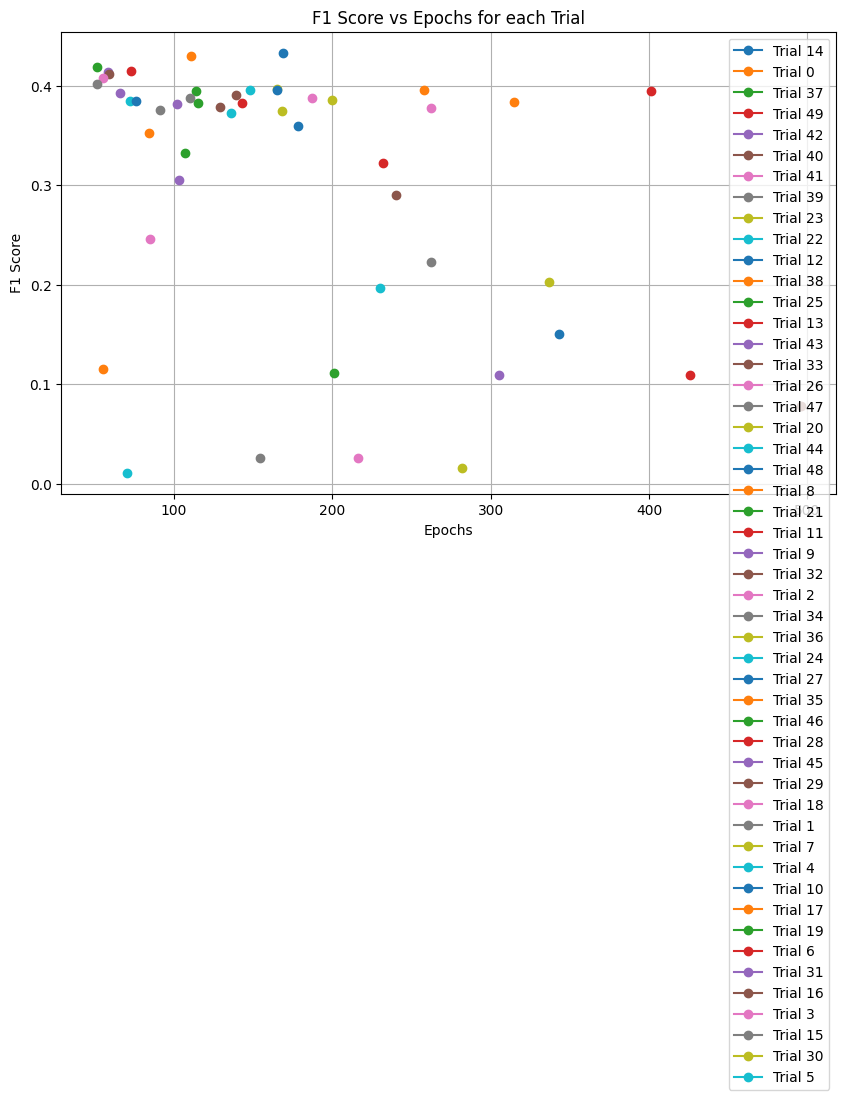

In [ ]:
# Plotting Graph

import matplotlib.pyplot as plt
import pandas as pd

# Plotting
plt.figure(figsize=(10, 6))

# Plot each trial
for trial_id, trial_data in df.iterrows():
    plt.plot(trial_data['config/epochs'], trial_data['f1'], marker='o', label=f"Trial {trial_id}")

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs for each Trial')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [ ]:
df

,f1,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,time_since_restore,iterations_since_restore,config/batch_size,config/hidden_dim,config/optimizer,config/lr,config/epochs,config/activation,config/dropout,logdir
14,0.433040,1736699495,None,False,169,161f5ce5,2025-01-12_16-31-35,0.294483,54.413531,10686,...,54.413531,169,16,272,Adagrad,0.009639,169,Tanh,0.494176,161f5ce5
0,0.429658,1736698885,None,False,111,8e320643,2025-01-12_16-21-25,0.388234,38.815111,7143,...,38.815111,111,16,304,AdamW,0.000083,111,ReLU,0.464377,8e320643
37,0.418681,1736700093,None,False,51,eab2ecf2,2025-01-12_16-41-33,0.304234,17.402016,15097,...,17.402016,51,16,100,Adam,0.000640,51,Tanh,0.341036,eab2ecf2
49,0.415042,1736700700,None,False,73,51c9a407,2025-01-12_16-51-40,0.174120,14.743676,18533,...,14.743676,73,32,396,NAdam,0.000519,73,LeakyReLU,0.267403,51c9a407
42,0.413239,1736700373,None,True,30,b89e0353,2025-01-12_16-46-13,1.114061,36.655647,16582,...,36.655647,30,4,160,Adam,0.000256,58,LeakyReLU,0.306569,b89e0353
40,0.411327,1736700288,None,False,59,1099c771,2025-01-12_16-44-48,1.323119,70.770075,15936,...,70.770075,59,4,74,Adam,0.000308,59,LeakyReLU,0.305165,1099c771
41,0.408036,1736700331,None,True,30,54e3c2db,2025-01-12_16-45-31,1.173721,37.709085,16330,...,37.709085,30,4,153,Adam,0.000286,55,ReLU,0.302561,54e3c2db
39,0.402019,1736700212,None,True,30,ea3752ea,2025-01-12_16-43-32,1.152220,38.363469,15677,...,38.363469,30,4,190,Adam,0.000320,51,ReLU,0.324106,ea3752ea
23,0.396370,1736699751,None,True,30,f63147d0,2025-01-12_16-35-51,0.360581,10.851299,12616,...,10.851299,30,16,83,AdamW,0.009790,165,Tanh,0.409995,f63147d0
22,0.395882,1736699734,None,True,30,e785c073,2025-01-12_16-35-34,0.330379,11.678400,12468,...,11.678400,30,16,87,AdamW,0.008924,148,Tanh,0.412796,e785c073


In [ ]:
# Saving the df
df.to_csv('hyperparameter_run2.csv', index=True)


# Model with best hyperparamter from first search

In [ ]:
# Data prepration for PyTorch

from torch.utils.data import DataLoader, TensorDataset

# Combine embeddings and labels into TensorDataset
train_dataset = TensorDataset(X_train_sonar, y_train_sonar)
test_dataset = TensorDataset(X_test_sonar, y_test_sonar)

# Create DataLoader for batching
train_loader2 = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader2 = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model Initialization
input_dim = 1024       # Dimension of SONAR embeddings
hidden_dim2 = 64       # Number of hidden units(Hyperparameter)
output_dim = len(set(y_train_sonar.numpy()))  # Number of unique classes

model2 = Sonar_Classifier(input_dim, hidden_dim2, output_dim, activation=nn.LeakyReLU, dropout=0.27275822253553167)
model2.to(device= device) # Train model2 in what's available
print(model2)

# Loss function and optimizer
criterion2 = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer2 = optim.Adamax(model2.parameters(), lr=0.0015459934790738002)

Sonar_Classifier(
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.27275822253553167, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


Epoch 1/50, Train Loss: 1.7785, Test Loss: 1.7652
Epoch 2/50, Train Loss: 1.7495, Test Loss: 1.7444
Epoch 3/50, Train Loss: 1.7200, Test Loss: 1.7227
Epoch 4/50, Train Loss: 1.6917, Test Loss: 1.6927
Epoch 5/50, Train Loss: 1.6439, Test Loss: 1.6551
Epoch 6/50, Train Loss: 1.6141, Test Loss: 1.6167
Epoch 7/50, Train Loss: 1.5706, Test Loss: 1.5788
Epoch 8/50, Train Loss: 1.5154, Test Loss: 1.5467
Epoch 9/50, Train Loss: 1.4764, Test Loss: 1.5155
Epoch 10/50, Train Loss: 1.4376, Test Loss: 1.4902
Epoch 11/50, Train Loss: 1.4176, Test Loss: 1.4710
Epoch 12/50, Train Loss: 1.3698, Test Loss: 1.4522
Epoch 13/50, Train Loss: 1.3542, Test Loss: 1.4360
Epoch 14/50, Train Loss: 1.3208, Test Loss: 1.4212
Epoch 15/50, Train Loss: 1.3017, Test Loss: 1.4119
Epoch 16/50, Train Loss: 1.2654, Test Loss: 1.4110
Epoch 17/50, Train Loss: 1.2542, Test Loss: 1.3825
Epoch 18/50, Train Loss: 1.2343, Test Loss: 1.3705
Epoch 19/50, Train Loss: 1.2132, Test Loss: 1.3720
Epoch 20/50, Train Loss: 1.1796, Test Lo

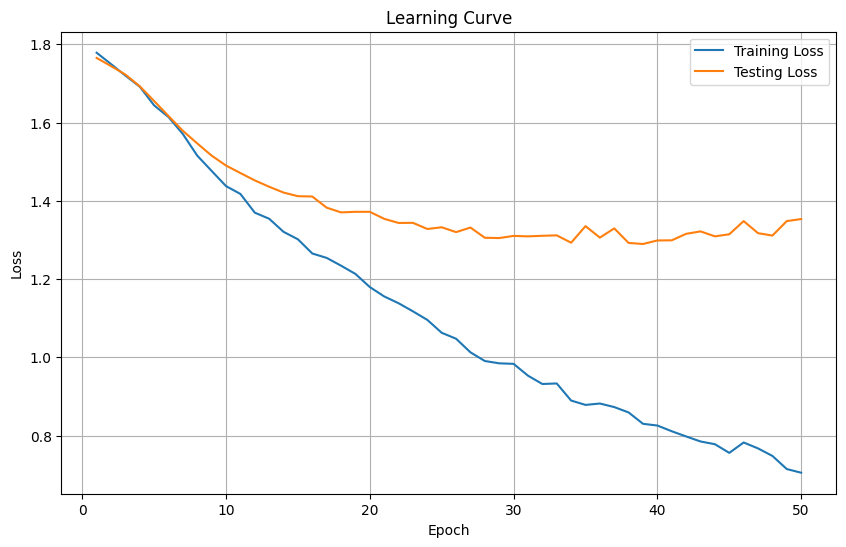

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store training and testing losses
train_losses2 = []
test_losses2 = []

# Training and evaluation loop
epochs = 50  # Number of epochs
for epoch in range(epochs):
    # Training phase
    model2.train()
    train_loss = 0
    for X_batch, y_batch in train_loader2:
        optimizer2.zero_grad()
        outputs = model2(X_batch)
        loss = criterion2(outputs, y_batch.long())  # Ensure labels are long type
        loss.backward()
        # Prevent exploading gradients by clipping
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        optimizer2.step()
        train_loss += loss.item()
    train_loss /= len(train_loader2)  # Average loss for training
    train_losses2.append(train_loss)

    # Testing phase
    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader2:
            outputs = model2(X_batch)
            loss = criterion2(outputs, y_batch.long())
            test_loss += loss.item()
    test_loss /= len(test_loader2)  # Average loss for testing
    test_losses2.append(test_loss)

    # # Update learning rate based on test loss
    # scheduler.step(test_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses2, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses2, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       174
           1       0.75      0.60      0.67       278
           2       0.18      0.24      0.21        49
           3       0.29      0.30      0.29        20
           4       0.28      0.32      0.30        22
           5       0.27      0.41      0.33        29

    accuracy                           0.62       572
   macro avg       0.43      0.46      0.44       572
weighted avg       0.65      0.62      0.63       572



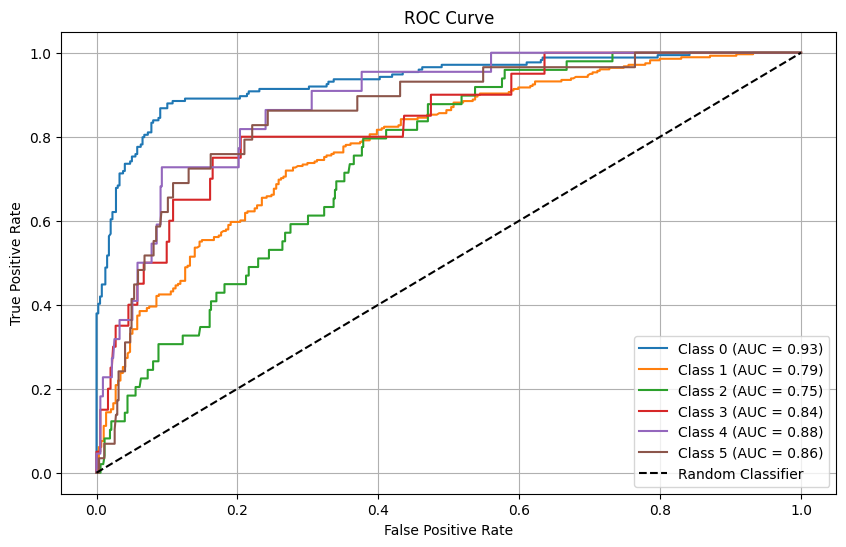

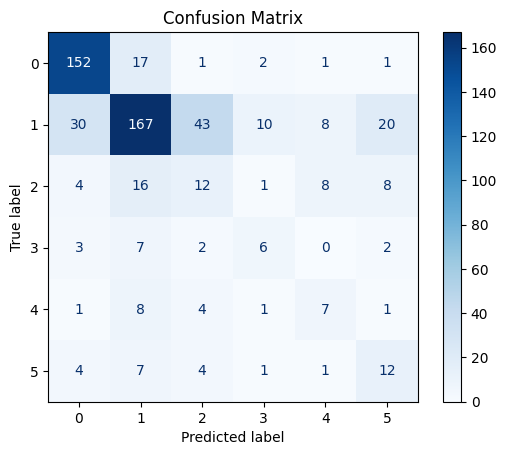

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set, generate a classification report, plot the ROC curve,
    and display the confusion matrix.

    Parameters:
        model: Trained PyTorch model
        test_loader: DataLoader for the test set

    Returns:
        None
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Model predictions
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted classes

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Determine the number of classes
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # ROC Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model2, test_loader2)

## LSTM

In [ ]:
# Reshape for LSTM: (num_samples, 1, 1024)
X_train_sonar_lstm = X_train_sonar.reshape((X_train_sonar.shape[0], 1, 1024))
X_test_sonar_lstm = X_test_sonar.reshape((X_test_sonar.shape[0], 1, 1024))

print(X_test_sonar_lstm)



tensor([[[-1.5528e-03, -2.5087e-03, -1.0142e-03,  ..., -5.4943e-03,
           4.5500e-03,  1.6872e-04]],

        [[-2.5853e-03,  4.3708e-04, -2.6136e-05,  ...,  3.7843e-03,
           1.0501e-03, -1.1041e-03]],

        [[ 2.4939e-03, -3.7487e-03,  3.4550e-03,  ..., -7.3771e-04,
          -1.1431e-03, -1.1719e-03]],

        ...,

        [[-4.3884e-03,  4.1417e-03, -3.0299e-04,  ..., -1.4478e-04,
           1.8161e-03, -7.6605e-04]],

        [[ 2.1117e-03,  3.3301e-04, -6.4556e-03,  ..., -3.0298e-04,
          -1.9006e-04, -7.7038e-03]],

        [[-2.1635e-03,  6.1458e-03,  7.3193e-03,  ...,  1.7448e-04,
           1.0264e-02, -9.4419e-04]]])


In [ ]:
import torch.nn as nn
import torch.optim as optim

class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTM_Classifier, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # Fully connected layer after LSTM
        self.fc = nn.Linear(hidden_dim, output_dim)

        # # Dropout layer for regularization
        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)

        # Pass data through LSTM
        lstm_out, (hn, cn) = self.lstm(x)

        # Take the final hidden state for classification
        final_hidden_state = hn[-1]  # Get the last hidden state

        # # Dropout for regularization
        # out = self.dropout(final_hidden_state)

        # Fully connected layer to output
        out = self.fc(final_hidden_state)

        return out

# Initialize model2, loss function, and optimizer2
model2 = LSTM_Classifier(input_dim=1024, hidden_dim=128, output_dim=6)
model2.to(device= device) # Train model in what's available
print(model2)

LSTM_Classifier(
  (lstm): LSTM(1024, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Combine embeddings and labels into TensorDataset
train_dataset_lstm = TensorDataset(X_train_sonar_lstm, y_train_sonar)
test_dataset_lstm = TensorDataset(X_test_sonar_lstm, y_test_sonar)

train_loader = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_lstm, batch_size=32, shuffle=False)



Epoch 1/100, Train Loss: 1.7918, Test Loss: 1.7863
Epoch 2/100, Train Loss: 1.7841, Test Loss: 1.7803
Epoch 3/100, Train Loss: 1.7684, Test Loss: 1.7639
Epoch 4/100, Train Loss: 1.7365, Test Loss: 1.7251
Epoch 5/100, Train Loss: 1.6732, Test Loss: 1.6649
Epoch 6/100, Train Loss: 1.5881, Test Loss: 1.6021
Epoch 7/100, Train Loss: 1.5063, Test Loss: 1.5499
Epoch 8/100, Train Loss: 1.4185, Test Loss: 1.5216
Epoch 9/100, Train Loss: 1.3411, Test Loss: 1.4569
Epoch 10/100, Train Loss: 1.2520, Test Loss: 1.4217
Epoch 11/100, Train Loss: 1.1845, Test Loss: 1.3928
Epoch 12/100, Train Loss: 1.1160, Test Loss: 1.3847
Epoch 13/100, Train Loss: 1.0576, Test Loss: 1.3915
Epoch 14/100, Train Loss: 0.9908, Test Loss: 1.3388
Epoch 15/100, Train Loss: 0.9441, Test Loss: 1.3138
Epoch 16/100, Train Loss: 0.9023, Test Loss: 1.3213
Epoch 17/100, Train Loss: 0.8521, Test Loss: 1.3450
Epoch 18/100, Train Loss: 0.8046, Test Loss: 1.3419
Epoch 19/100, Train Loss: 0.7811, Test Loss: 1.3296
Epoch 20/100, Train L

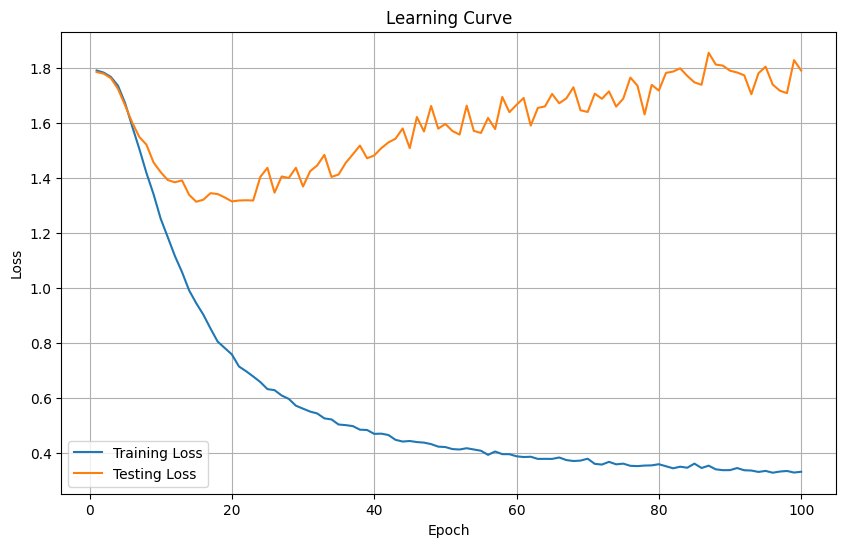

In [ ]:

criterion2 = nn.CrossEntropyLoss(weight= class_weights_tensor)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

# Initialize lists to store training and testing losses
train_losses_lstm = []
test_losses_lstm = []

# Training and evaluation loop
epochs = 100
for epoch in range(epochs):
    # Training phase
    model2.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer2.zero_grad()
        outputs = model2(X_batch)
        loss = criterion2(outputs, y_batch.long())  # Ensure labels are long type
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)  # Average loss for training
    train_losses_lstm.append(train_loss)

    # Testing phase
    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model2(X_batch)
            loss = criterion2(outputs, y_batch.long())
            test_loss += loss.item()
    test_loss /= len(test_loader)  # Average loss for testing
    test_losses_lstm.append(test_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses_lstm, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses_lstm, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()